### Preparatory steps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import _functions_sql as fs
import seaborn as sns
import numpy as np
import circlify #needed for creating bubble diagrams

In [ ]:
# Define lists for product categories

items = df_trade_ger.item.unique().tolist()
item_categories = world_emissions.item_category.unique().tolist()
item_groups = world_emissions.item_group.unique().tolist()

meat = list(filter(lambda x: 'Meat' in x, items))
milk_eggs= list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
crops = list(set(items) - set(meat + milk_eggs))

# Create a list of 21 selected items
selected_items = ['Barley', 'Beans, dry', 'Hen eggs in shell, fresh', 'Maize (corn)', 'Meat of buffalo, fresh or chilled', 'Meat of cattle with the bone, fresh or chilled', 'Meat of chickens, fresh or chilled', 'Meat of goat, fresh or chilled', 'Meat of pig with the bone, fresh or chilled', 'Meat of sheep, fresh or chilled', 'Millet', 'Oats', 'Potatoes', 'Raw milk of cattle', 'Raw milk of sheep', 'Rice', 'Rye', 'Sorghum', 'Soya beans', 'Sugar cane', 'Wheat']

selected_meat = list(filter(lambda x: 'Meat' in x, selected_items))
selected_milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, selected_items))
selected_crops = list(set(selected_items) - set(selected_meat + selected_milk_eggs) - {'Rice'}) #removing rice from the crop list since it's an outlier

In [ ]:
selected_milk_eggs

In [ ]:
item_categories = world_emissions.item_category.unique().tolist()
item_groups = world_emissions.item_group.unique().tolist()
items = world_emissions.item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
rice_wheat_maize = list(filter(lambda x: 'Rice' in x or 'Wheat' in x or 'Maize' in x, items))
remaining = list(set(items) - set(meat + milk_eggs + rice_wheat_maize))

In [ ]:
# import production & emissions table from database
df_prod_emis = fs.get_dataframe("SELECT * from production_and_emissions_new")

In [ ]:
df_prod_emis['prod_pop'] = df_prod_emis['production_in_t'] / df_prod_emis['population']
df_prod_emis['emis_pop'] = df_prod_emis['emissions_co2eq_combined_in_kt'] / df_prod_emis['population']
df_prod_emis = df_prod_emis[df_prod_emis['item_category'] != 'Live Animals']
df_prod_emis = df_prod_emis[~df_prod_emis['country'].isin(['China', 'China, Hong Kong SAR'])]

In [ ]:
# Create a world production table 
world_production = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021)]

In [ ]:
# Create a world emissions table
world_emissions = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021) & (df_prod_emis.emissions_co2eq_combined_in_kt.notnull())]

## Germany: production vs import volumes 

### Create a trade & production table for Germany

In [ ]:
df_trade_ger = fs.get_dataframe("SELECT * FROM fao_trade_matrix WHERE reporting_country = 'Germany'")

In [ ]:
df_trade_ger.head()

In [ ]:
df_production_ger = fs.get_dataframe("SELECT * FROM production_and_emissions_new WHERE country = 'Germany'")

In [ ]:
df_production_ger.head()

In [ ]:
df_trade_ger_grouped = df_trade_ger.groupby(['reporting_country', 'year', 'item']).sum().reset_index()

In [ ]:
df_trade_ger_grouped.head()

In [ ]:
df_trade_ger_grouped.drop(columns = ['reporting_country', 'partner_country', 'unit'], inplace = True)

In [ ]:
df_production_ger_grouped = df_production_ger.groupby(['country', 'year','item']).sum().reset_index()

In [ ]:
df_production_ger_grouped.head()

In [ ]:
df_production_ger_grouped.drop(columns = ['country', 'continent', 'subcontinent', 'special_area', 'population',], inplace = True)

In [ ]:
# df_trade_prod_ger_grouped.dropna(subset = ['import_quantity', 'production_in_t'], inplace=True)

In [ ]:
df_trade_prod_ger  = pd.merge(df_trade_ger_grouped,df_production_ger_grouped[['item', 'year','production_in_t']], left_on = ['item', 'year'], right_on = ['item', 'year'], how = 'left')

In [ ]:
df_trade_prod_ger.head()

In [ ]:
# Filter for 2020
df_trade_prod_ger_2020 = df_trade_prod_ger[df_trade_prod_ger['year'] == 2020]

In [ ]:
# Filter for selected items
df_trade_prod_ger_2020_specific = df_trade_prod_ger_2020[df_trade_prod_ger_2020['item'].isin(selected_items)]

In [ ]:
df_trade_prod_ger_2020_specific

In [ ]:
# Drop rows with NAs in the production column
df_trade_prod_ger_2020_specific.dropna(subset = 'production_in_t', inplace = True)

In [ ]:
# Filter for 2020
df_trade_prod_ger_2020 = df_trade_prod_ger[df_trade_prod_ger['year'] == 2020]

# Filter for specific items
df_trade_prod_ger_2020_specific = df_trade_prod_ger_2020[df_trade_prod_ger_2020['item'].isin(selected_items)]

# Calculate the share of production and import for each selected product in percentage
df_trade_prod_ger_2020_specific['production_share'] = (df_trade_prod_ger_2020_specific['production_in_t'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100
df_trade_prod_ger_2020_specific['import_share'] = (df_trade_prod_ger_2020_specific['import_quantity'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100

# Group by product and sum the shares
df_grouped = df_trade_prod_ger_2020_specific.groupby('item')[['production_share', 'import_share']].sum()
df_grouped= df_grouped.sort_values(by='production_share', ascending=False)
# Plotting
ax = df_grouped.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Share of Production vs Import, Germany, 2020 ')
plt.xlabel('Share, %')
plt.ylabel('Product')
plt.legend()
plt.show()

### Emission intensity: production vs import

In [ ]:
df_emissions_ger = fs.get_dataframe("SELECT * FROM mk_import_emissions")

In [ ]:
df_emissions_ger

In [ ]:
df_emission_intensity_ger  = pd.merge(df_emissions_ger,df_production_ger_grouped[['item', 'year','emissions_co2eq_combined_in_kt', 'emissions_intensity_combined_in_kg_co2eq_per_kg']], left_on = ['item', 'import_year'], right_on = ['item', 'year'], how = 'left')

In [ ]:
df_emission_intensity_ger.head()

In [ ]:
df_emission_intensity_ger.drop(columns = ['total_import_share', 'year'], inplace = True)

In [ ]:
df_emission_intensity_ger.rename(columns={'emissions_co2eq_combined_in_kt': 'total_production_emission_amount', 'emissions_intensity_combined_in_kg_co2eq_per_kg': 'total_production_emissions_intensity'}, inplace = True)

In [ ]:
df_emission_intensity_ger_2020

In [ ]:

# Function to create horizontal grouped bar chart
def create_grouped_bar_chart(products, title):

    # Filter dataframe based on selected products
    df_selected = df_emission_intensity_ger_2020[df_emission_intensity_ger_2020['item'].isin(products)]

    # Sort the DataFrame based on total_production_emission_amount
    df_selected_sorted = df_selected.sort_values(by='total_import_emission_intensity', ascending=True)

    # Calculate the size based on the number of bars and scale of values
    num_bars = len(df_selected_sorted)
    bar_height = min(0.35, 8 / num_bars)  # Adjust 6 based on your preference for the overall height

    # Calculate the figure size based on the number of bars and scale of values
    fig_size = (8, num_bars * 1)

    plt.figure(figsize=fig_size)

    # Define the index based on the length of the DataFrame
    index = np.arange(len(df_selected_sorted))

    # Plot production emissions
    plt.barh(index, df_selected_sorted['total_production_emissions_intensity'], bar_height, color='blue', label='Production')

    # Plot import emissions
    plt.barh(index + bar_height, df_selected_sorted['total_import_emission_intensity'], bar_height, color='orange', label='Import')

    # Customize the plot
    plt.xlabel('Emission Intensity, kg CO2eq/kg')
    plt.title(title)
    plt.yticks(index + bar_height / 2, df_selected_sorted['item'])
    plt.legend()

    # Show the plot
    plt.show()

# Create separate plots for each product list
create_grouped_bar_chart(selected_meat, 'Emission Intensity, Meat Products')
create_grouped_bar_chart(selected_crops, 'Emission Intensity, Crops')
create_grouped_bar_chart(selected_milk_eggs, 'Emission Intensity, Milk and Eggs')

### Bubble charts

#### Meat emissions

Creating a bubble chart for worldwide meat emissions in 2020.

In [ ]:
# Defining new, shorter names for meat food items
def meat_type(food_item):
    if food_item == 'Meat of cattle with the bone, fresh or chilled':
        return 'cattle'
    elif food_item == 'Meat of pig with the bone, fresh or chilled':
        return 'pigs'
    elif food_item == 'Meat of chickens, fresh or chilled':
        return 'chickens'
    return 'other animals'

world_emissions_meat = world_emissions[world_emissions.item_group == 'Meat, Total']
world_emissions_meat['meat_type'] = world_emissions_meat.item.apply(lambda x: meat_type(x))

In [ ]:
meat = world_emissions_meat.meat_type.unique().tolist()
meat

In [ ]:
world_emissions_grouped = world_emissions[['item', 'year', 'emissions_co2eq_combined_in_kt']].groupby(['item', 'year'], as_index=False).agg('mean')

In [ ]:
world_emissions_grouped_meat = world_emissions_meat[['meat_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['meat_type', 'year'], as_index=False).agg('sum')

In [ ]:
world_emissions_grouped_2020 = world_emissions_grouped_meat[world_emissions_grouped_9['year']== 2020]

In [ ]:
world_emissions_grouped_2020_sorted = world_emissions_grouped_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [ ]:
world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'] = \
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].round()

In [ ]:
world_emissions_grouped_2020_sorted.head()

In [ ]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

In [ ]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4']

# Create a dictionary of font sizes for each label 
font_sizes = {
    'cattle': 12,
    'other animals': 10,
    'pigs': 10,
    'chickens': 10
}


# Remove axes
ax.axis('off')

# Title
ax.set_title('Meat emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_2020_sorted['meat_type']

# Create a list of emission shares in % 
percentages = [2.1, 6.5, 23.5, 67.8]

# print circles
for circle, label, color, percentage in zip(circles, labels, colors, percentages):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.95, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))

    # Concatenate label with percentage
    label_with_percentage = f"{label}\n{percentage:.1f}%"

    ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 10))

#### Crop emissions

In [ ]:
def crop_type(food_item):
    if food_item == 'Rice':
        return 'rice'
    elif food_item == 'Wheat':
        return 'wheat'
    elif food_item == 'Maize (corn)':
        return 'maize'
    elif food_item == 'Sugar cane':
        return 'sugar cane'
    return 'other crops'

world_emissions_crops = world_emissions[world_emissions.item_category == 'Crops, primary']
world_emissions_crops['crop_type'] = world_emissions_crops.item.apply(lambda x: crop_type(x))

In [ ]:
crops = world_emissions_crops.crop_type.unique().tolist()
crops

In [ ]:
world_emissions_grouped_crops = world_emissions_crops[['crop_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['crop_type', 'year'], as_index=False).agg('sum')

In [ ]:
world_emissions_grouped_crops.head()

In [ ]:
world_emissions_grouped_crops_2020 = world_emissions_grouped_crops[world_emissions_grouped_crops['year']== 2020]

In [ ]:
world_emissions_grouped_crops_2020_sorted = world_emissions_grouped_crops_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [ ]:
world_emissions_grouped_crops_2020_sorted.head()

In [ ]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_crops_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Sort circles by their x-coordinate to distribute them more equally
#circles.sort(key=lambda circle: circle.x)

In [ ]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#d62728', '#ff7f0e', '#9467bd', '#1f77b4','#2ca02c']


# Create a dictionary of font sizes for each label 
font_sizes = {
    'rice': 12,
    'maize': 12,
    'wheat': 12,
    'other crops': 12, 
    'sugar cane': 12
}

# Remove axes
ax.axis('off')

# Title
ax.set_title('Crops emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_crops_2020_sorted['crop_type']

# Create a list of emission shares in % 
percentages = [0.2, 5.3, 6.4, 7.3, 80.9 ]

# print circles
for circle, label, color, percentage in zip(circles, labels, colors, percentages):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*1, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))

    # Concatenate label with percentage
    label_with_percentage = f"{label}\n{percentage:.1f}%"

    #ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 10))
    
    # Use annotate with xytext to place the label on the right side of the bubble for "sugar cane" only
    if label == 'sugar cane':
        ax.annotate(label_with_percentage, (circle.x, circle.y), xytext=(circle.x + r*2.5, circle.y),
                    ha='left', va='center', fontsize=font_sizes.get(label, 10), arrowprops=dict(facecolor='black', width=2, headwidth=3, headlength =1))
    else:
        ax.annotate(label_with_percentage, (circle.x, circle.y), ha='center', va='center', fontsize=font_sizes.get(label, 10))

plt.show()



### Scatterplot emission intensity & import amount

In [ ]:
#Create a data frame
df_import_amount_emissions_ger = pd.merge(df_trade_prod_ger[['item', 'year', 'import_quantity']], df_emissions_ger[['item', 'import_year','total_import_emission_intensity', 'total_import_emission_amount']], left_on = ['item', 'year'], right_on = ['item', 'import_year'], how = 'left')

In [ ]:
# Filter for selected items
df_import_amount_emissions_ger = df_import_amount_emissions_ger[df_import_amount_emissions_ger['item'].isin(selected_items)]

In [ ]:
# Filter for 2020
df_import_amount_emissions_ger = df_import_amount_emissions_ger[df_import_amount_emissions_ger['year']==2020]

In [693]:
def create_grouped_scatterplot(products):
    sns.set_style("darkgrid")
    plt.figure(figsize=(6, 6))

    # Filter dataframe based on selected products
    df_selected = df_import_amount_emissions_ger[df_import_amount_emissions_ger['item'].isin(products)]
    df_selected.dropna(subset=['total_import_emission_amount'], inplace=True)
    
    # Create a color mapping for each unique product
    unique_products = df_selected['item'].unique()
    colors = sns.color_palette("husl", n_colors=len(unique_products))
    color_mapping = dict(zip(unique_products, colors))

    # Use the color mapping for both scatterplot and legend
    sns.scatterplot(data=df_selected, x="import_quantity", y="total_import_emission_intensity",
                    size="total_import_emission_amount", hue='item', sizes=(50, 1000),
                    palette=color_mapping)
    
    plt.xlabel("Import, t")
    plt.ylabel("Emission Intensity, kg CO2 eq/kg")

    # Create custom legend using the color mapping
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[item], markersize=8, label=item)
                      for item in unique_products]

    # Add a transparent background to the legend
    legend = plt.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper right', fontsize=10, scatterpoints=1)
    legend.get_frame().set_alpha(0.5)  # Set legend background transparency

    plt.show()


In [697]:
def create_grouped_scatterplot(products, name_mapping=None):
    sns.set_style("darkgrid")
    plt.figure(figsize=(6, 6))

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_selected = df_import_amount_emissions_ger[df_import_amount_emissions_ger['item'].isin(products)].copy()
    df_selected.dropna(subset=['total_import_emission_amount'], inplace=True)
    
    # Use the provided name_mapping or create a default mapping
    if name_mapping is None:
        name_mapping = {item: item for item in products}
    
    # Rename items in the DataFrame
    df_selected['item'] = df_selected['item'].map(name_mapping)

    # Create a color mapping for each unique product
    unique_products = df_selected['item'].unique()
    colors = sns.color_palette("husl", n_colors=len(unique_products))
    color_mapping = dict(zip(unique_products, colors))

    # Use the color mapping for both scatterplot and legend
    sns.scatterplot(data=df_selected, x="import_quantity", y="total_import_emission_intensity",
                    size="total_import_emission_amount", hue='item', sizes=(50, 1000),
                    palette=color_mapping)
    
    plt.xlabel("Import, t")
    plt.ylabel("Emission Intensity, kg CO2 eq/kg")

    # Create custom legend using the color mapping
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[item], markersize=8, label=item)
                      for item in unique_products]

    # Add a transparent background to the legend
    legend = plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper right', fontsize=10, scatterpoints=1)
    legend.get_frame().set_alpha(0.5)  # Set legend background transparency

    plt.show()

In [667]:
meat_and_milk = ['Meat of buffalo, fresh or chilled',
 'Meat of cattle with the bone, fresh or chilled',
 'Meat of chickens, fresh or chilled',
 'Meat of goat, fresh or chilled',
 'Meat of pig with the bone, fresh or chilled',
 'Meat of sheep, fresh or chilled',
 'Hen eggs in shell, fresh', 
 'Raw milk of cattle', 
 'Raw milk of sheep']

In [ ]:
crops_and_vegetables = ['Maize (corn)',
 'Wheat',
 'Sorghum',
 'Potatoes',
 'Rye',
 'Millet',
 'Soya beans',
 'Barley',
 'Oats',
 'Sugar cane',
 'Beans, dry', 
 'Rice']

In [683]:
name_mapping_animal_products = {'Meat of buffalo, fresh or chilled':'Buffalo meat', 'Meat of cattle with the bone, fresh or chilled':'Cattle meat', 'Meat of chickens, fresh or chilled':'Chicken meat', 'Meat of goat, fresh or chilled':'Goat meat', 'Meat of pig with the bone, fresh or chilled':'Pig meat', 'Meat of sheep, fresh or chilled':'Sheep meat', 'Hen eggs in shell, fresh':'Chicken eggs', 'Raw milk of cattle':'Raw milk of cattle', 'Raw milk of sheep':'Raw milk of sheep'}

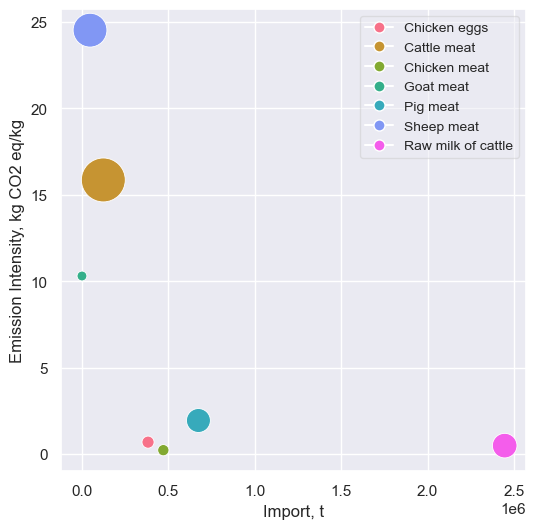

In [699]:
# Create a scatterplot for animal products
name_mapping_animal_products = {'Meat of buffalo, fresh or chilled':'Buffalo meat',
                                 'Meat of cattle with the bone, fresh or chilled':'Cattle meat',
                                   'Meat of chickens, fresh or chilled':'Chicken meat',
                                     'Meat of goat, fresh or chilled':'Goat meat',
                                       'Meat of pig with the bone, fresh or chilled':'Pig meat',
                                         'Meat of sheep, fresh or chilled':'Sheep meat',
                                           'Hen eggs in shell, fresh':'Chicken eggs',
                                             'Raw milk of cattle':'Raw milk of cattle',
                                               'Raw milk of sheep':'Raw milk of sheep'}

create_grouped_scatterplot(meat_and_milk, name_mapping_animal_products)

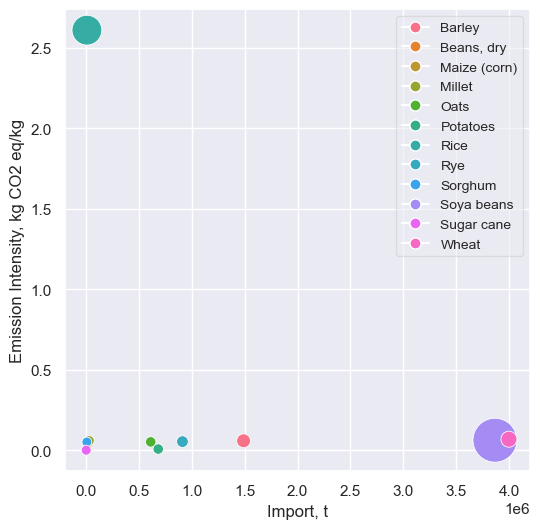

In [700]:
# Create a scatterplot for crops and vegetables
create_grouped_scatterplot(crops_and_vegetables)

### Rice & soya beans import 

In [705]:
df_trade_ger_grouped = df_trade_ger.groupby(['reporting_country', 'partner_country', 'year', 'item']).sum().reset_index()

In [713]:
df_trade_ger_grouped.head()

,reporting_country,partner_country,year,item,item_code,unit,export_quantity,export_value,import_quantity,import_value
0,Germany,Afghanistan,1991,Apples,1030,1000 USDt,3.0,4.0,0.0,0.0
1,Germany,Afghanistan,1991,"Beer of barley, malted",102,1000 USDt,147.0,99.0,0.0,0.0
2,Germany,Afghanistan,1991,Beeswax,2366,1000 USDt,4.0,17.0,0.0,0.0
3,Germany,Afghanistan,1991,Chocolate products nes,1332,1000 USDt,1.0,1.0,0.0,0.0
4,Germany,Afghanistan,1991,Cigarettes,1656,1000 USDt,82.0,576.0,0.0,0.0


In [707]:
df_emissions_ger.head()

,item,import_year,total_import_share,total_import_emission_intensity,total_import_emission_amount
0,Barley,1991,1.0,0.055287,212.018670
1,Barley,1992,1.0,0.059286,256.927590
2,Barley,1993,1.0,0.058420,370.455123
3,Barley,1994,1.0,0.059512,302.021275
4,Barley,1995,1.0,0.060029,322.431067


In [711]:
df_production_grouped = df_production.groupby(['country', 'year','item']).sum().reset_index()

In [712]:
df_production_grouped.head()

,country,year,item,continent,subcontinent,special_area,population,item_code,item_group,item_category,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Afghanistan,1961,Apples,Asia,Southern Asia,Land Locked Developing Countries,8790140,515,Fruit Primary,"Crops, primary",...,0.00,0.0000,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00
1,Afghanistan,1961,Apricots,Asia,Southern Asia,Land Locked Developing Countries,8790140,526,Fruit Primary,"Crops, primary",...,0.00,0.0000,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00
2,Afghanistan,1961,Asses,Asia,Southern Asia,Land Locked Developing Countries,8790140,1107,-,Live Animals,...,13.78,0.6465,578.4970,0.00,FAO TIER 1,0.0,0.0,0.0,578.4970,0.00
3,Afghanistan,1961,Barley,Asia,Southern Asia,Land Locked Developing Countries,8790140,44,"Cereals, primary","Crops, primary",...,0.00,0.1141,34.0018,0.08,FAO TIER 1,0.0,0.0,0.0,34.0018,0.08
4,Afghanistan,1961,Butter and ghee of sheep milk,Asia,Southern Asia,Land Locked Developing Countries,8790140,983,Butter and Ghee,Livestock processed,...,0.00,0.0000,0.0000,0.00,0,0.0,0.0,0.0,0.0000,0.00


In [745]:
test = pd.merge(df_trade_ger_grouped, df_production_grouped[['country', 'year', 'item','emissions_intensity_combined_in_kg_co2eq_per_kg']], left_on =['partner_country', 'year', 'item'], right_on = ['country', 'year', 'item'], how = 'left')

In [746]:
selected_items = ['Rice']

In [747]:
# Filter for selected items
test = test[test['item'].isin(selected_items)]

In [748]:
# Filter for 2020
test = test[test['year']==2020]

In [749]:
# Drop rows where emission intensity is NA
test.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'], inplace= True)

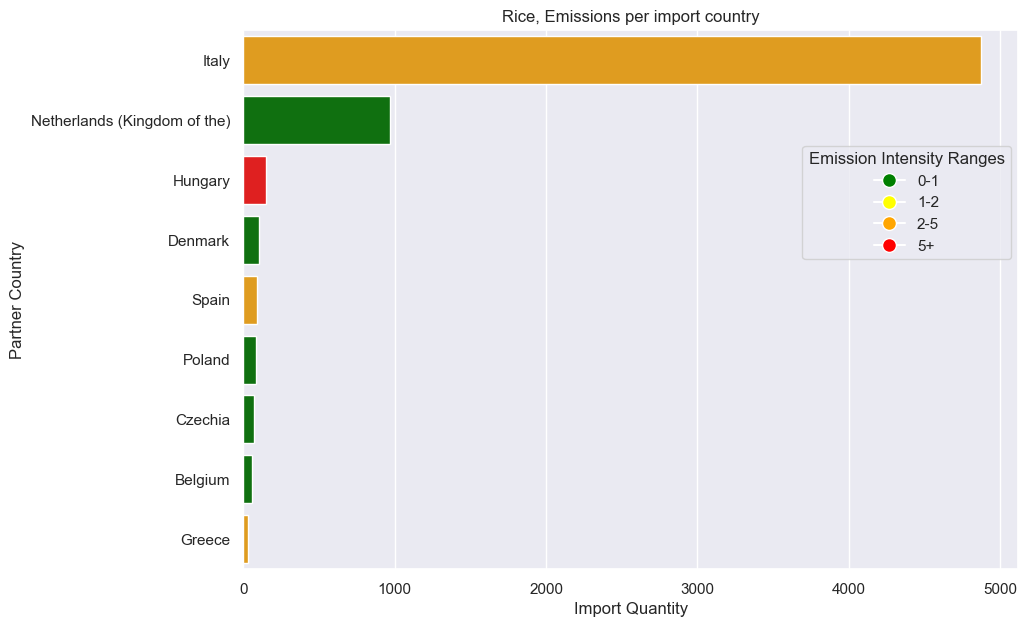

In [800]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 7))

# Filter the dataframe where import_quantity is greater than 30
test_filtered = test[test['import_quantity'] > 30]

# Sort the filtered dataframe by the import_quantity column in descending order
test_sorted = test_filtered.sort_values(by='import_quantity', ascending=False)

# Define emission intensity ranges and corresponding colors
emission_intensity_ranges = [(0, 1), (1, 2), (2, 5), (5, float('inf'))]
colors = ['green', 'yellow', 'orange', 'red']

# Create a custom color mapping based on emission intensity ranges
color_mapping = {val: color for val, color in zip(emission_intensity_ranges, colors)}

# Map the emission intensity values to corresponding colors
test_sorted['color'] = pd.cut(
    test_sorted['emissions_intensity_combined_in_kg_co2eq_per_kg'],
    bins=[range[0] for range in emission_intensity_ranges] + [float('inf')],
    labels=colors,
    right=False
)

# Plot the main bars using barplot with custom color mapping
bars = sns.barplot(
    x="import_quantity",
    y="partner_country",
    data=test_sorted,
    estimator=sum,
    errorbar=None,
    palette=test_sorted['color'],  # Use the 'color' column as the palette
)

# Create custom legend
legend_labels = [f'{range[0]}-{range[1]}' if range[1] != float('inf') else f'{range[0]}+' for range in emission_intensity_ranges]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1, 0.8), title='Emission Intensity Ranges', loc='upper right')

# Set labels and title
plt.xlabel('Import Quantity')
plt.ylabel('Partner Country')
plt.title('Rice, Emissions per import country')

# Display the plot
plt.show()


In [788]:
import numpy as np

# Sample data
data = {
    'country': ['Germany']*28,
    'partner_country': ['Azerbaijan', 'Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Finland', 'France', 'Ghana', 'Greece', 'Hungary',
                        'India', 'Ireland', 'Italy', 'Japan', 'Lithuania', 'Luxembourg', 'Netherlands (Kingdom of the)', 'Nigeria',
                        'Pakistan', 'Poland', 'Portugal', 'Republic of Korea', 'Romania', 'Saudi Arabia', 'Slovenia', 'Spain', 'Thailand', 'Uzbekistan', 'Viet Nam'],
    'emissions_intensity_combined_in_kg_co2eq_per_kg': [2.5908, 0.0, 5.509, 0.0, 0.0, 0.0, 23.0435, 0.8114, 2.3367, 29.2664, 0.8303, 0.0, 2.4633, 0.9286, 0.0, 0.0, 0.0, 0.0, 1.7203, 1.2072, 0.0, 3.3826, 1.0778, 15.6129, 3.4606, 0.0, 2.9895, 1.8064, 4.3018, 1.047]
}

df = pd.DataFrame(data)

# Determine meaningful bins
bins = np.histogram_bin_edges(df['emissions_intensity_combined_in_kg_co2eq_per_kg'], bins='auto')

# Convert bins to a list
bins_list = bins.tolist()

# Print the list of bins
print(bins_list)


ValueError: All arrays must be of the same length

### Create a production table

In [ ]:
# import production data from database
df_production = fs.get_dataframe('SELECT * FROM production_and_emissions_new')

In [ ]:
test= fs.get_dataframe("SELECT * FROM production_and_emissions_new WHERE item = 'Beans, dry' AND country= 'Germany'")

In [ ]:
test

In [ ]:
df_production['item'].unique()

In [ ]:
df_production.head()

### Emissions and production development over time

In [ ]:
# Create a list of items in the 'livestock_primary' category
livestock_primary = list(set(df_production[(df_production['item_category'] == 'Livestock primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [ ]:
# Create two separate lists for milk and meat items
livestock_meat = ['Meat of cattle with the bone, fresh or chilled',
 'Meat of buffalo, fresh or chilled',
 'Meat of pig with the bone, fresh or chilled',
 'Meat of sheep, fresh or chilled',
 'Meat of chickens, fresh or chilled',
 'Meat of goat, fresh or chilled']

livestock_milk = ['Raw milk of buffalo','Raw milk of goats','Raw milk of camel','Raw milk of sheep','Raw milk of cattle']

In [ ]:
# Create a list of items in the 'crops_primary' category
crops_primary = list(set(df_production[(df_production['item_category'] == 'Crops, primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [ ]:
# Remove rice from the list
crops_primary_wo_rice = ['Maize (corn)','Sugar cane','Barley','Potatoes','Millet','Wheat','Soya beans','Rye','Oats','Sorghum','Beans, dry']

In [ ]:
# Create a list for remaining items
rice_and_eggs = ['Hen eggs in shell, fresh', 'Rice']

In [ ]:
emissions_intensity = df_production[['item', 'year', 'emissions_intensity_combined_in_kg_co2eq_per_kg']].groupby(['item', 'year'], as_index=False).agg('median')

In [ ]:
emissions_intensity = emissions_intensity.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'])

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

We see an overall decrease in emission intensity among different product groups. This trend is especially strong for rice, eggs and some of the meat products.

In [ ]:
# Calculate total production amount per item and year
production_amount_item = df_production[['item', 'year', 'production_in_t']].groupby(['item', 'year'], as_index=False).agg('sum')

In [ ]:
production_amount_item.head()

At the same time, production of these items is growing rapidly, driven by the population growth. 
This is especially true for widely consumed items such as pork, beef and chicken meat, rice, sugar cane and cattle milk. 

In [ ]:
# Plot production development of meat and crop food items over time. 
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Production, t')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Production, t')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Production, t')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Production, t')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### Production by country

In [ ]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'production_in_t']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [ ]:
# Calculating production per capita
production_amount_country['production_per_capita'] = production_amount_country['production_in_t'] / production_amount_country['population']

In [ ]:
production_amount_country.head()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot the top-10 agricultural producers by total production
production_amount_country.sort_values(by='production_in_t', ascending=False)\
    .head(10).plot.bar(x='area', y='production_in_t', ax=axes[0], logy=False)
axes[0].set_title('Top-10 food producers by total production')
axes[0].get_legend().remove()
axes[0].set_ylabel('t')

# Plot the top-10 agricultural producers by production per capita
production_amount_country.sort_values(by='production_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='production_per_capita', ax=axes[1], logy=False)
axes[1].set_title('Top-10 food producers by production per capita')
axes[1].get_legend().remove()
axes[1].set_ylabel('t / capita')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Emissions by country

In [ ]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'emissions_co2eq_in_kt']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [ ]:
# Calculating emissions per capita
production_amount_country['emissions_per_capita'] = production_amount_country['emissions_co2eq_in_kt'] / production_amount_country['population']

In [ ]:
# Plot the top-10 countries by emission amount
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_co2eq_in_kt', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_co2eq_in_kt', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()

In [ ]:
# Plot the top-10 countries by emission amount per capita
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_per_capita', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission per capita amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()